# ID5059 2022-23: Coursework Assignment 1

## Acknowledgments

This assignment is loosely based on the first assignment set by [Tom Kelsey](https://www.st-andrews.ac.uk/computer-science/people/twk/) in the 2020-21 delivery of ID5059. It uses data from the [Flight status prediction dataset](https://www.kaggle.com/datasets/robikscube/flight-delay-dataset-20182022) on [Kaggle](https://www.kaggle.com), posted by [Rob Mulla](https://www.linkedin.com/in/rob-mulla/).

### Import Relevant Packages

In [42]:
!{sys.executable} -m pip install numpy pandas matplotlib scikit-learn | grep -v 'already satisfied'

import numpy as np
import pandas as pd
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import  RandomizedSearchCV, train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc

### Medium Data Set

In [43]:
# File paths
file_paths = [
    '/Users/liuzikai/Desktop/2_medium/Combined_Flights_med_2018.csv',
    '/Users/liuzikai/Desktop/2_medium/Combined_Flights_med_2019.csv',
    '/Users/liuzikai/Desktop/2_medium/Combined_Flights_med_2020.csv',
    '/Users/liuzikai/Desktop/2_medium/Combined_Flights_med_2021.csv',
    '/Users/liuzikai/Desktop/2_medium/Combined_Flights_med_2022.csv',
]

# Read each CSV into a DataFrame
dfs = [pd.read_csv(file_path) for file_path in file_paths]

# Combine all DataFrames into one
flights = pd.concat(dfs, ignore_index=True)



In [44]:
display(flights)

,FlightDate,Airline,Origin,Dest,Cancelled,Diverted,CRSDepTime,CRSElapsedTime,Distance,Year,...,DestState,DestStateFips,DestStateName,DestWac,DepTimeBlk,CRSArrTime,ArrDel15,ArrTimeBlk,DistanceGroup,Disruption
0,2018-07-13,United Air Lines Inc.,LAX,ORD,0,0,1845,231,1744,2018,...,IL,17,Illinois,41,1800-1859,36,0.0,0001-0559,7,0.0
1,2018-06-26,Mesa Airlines Inc.,CRP,IAH,0,0,1757,60,201,2018,...,TX,48,Texas,74,1700-1759,1857,0.0,1800-1859,1,0.0
2,2018-07-03,Southwest Airlines Co.,ECP,HOU,0,0,945,105,571,2018,...,TX,48,Texas,74,0900-0959,1130,0.0,1100-1159,3,0.0
3,2018-10-28,United Air Lines Inc.,LAS,IAH,0,0,1015,171,1222,2018,...,TX,48,Texas,74,1000-1059,1506,0.0,1500-1559,5,0.0
4,2018-11-01,ExpressJet Airlines Inc.,IAH,TUL,0,0,1856,90,429,2018,...,OK,40,Oklahoma,73,1800-1859,2026,0.0,2000-2059,2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291930,2022-02-28,Delta Air Lines Inc.,DCA,ATL,0,0,1705,123,547,2022,...,GA,13,Georgia,34,1700-1759,1908,1.0,1900-1959,3,1.0
291931,2022-05-09,United Air Lines Inc.,DFW,EWR,0,0,800,206,1372,2022,...,NJ,34,New Jersey,21,0800-0859,1226,0.0,1200-1259,6,0.0
291932,2022-06-29,Delta Air Lines Inc.,ATL,CLT,0,0,1513,78,226,2022,...,NC,37,North Carolina,36,1500-1559,1631,1.0,1600-1659,1,1.0
291933,2022-01-02,American Airlines Inc.,TPA,ORD,0,0,1435,185,1011,2022,...,IL,17,Illinois,41,1400-1459,1640,1.0,1600-1659,5,1.0


### COVID-19 Impact Visualization

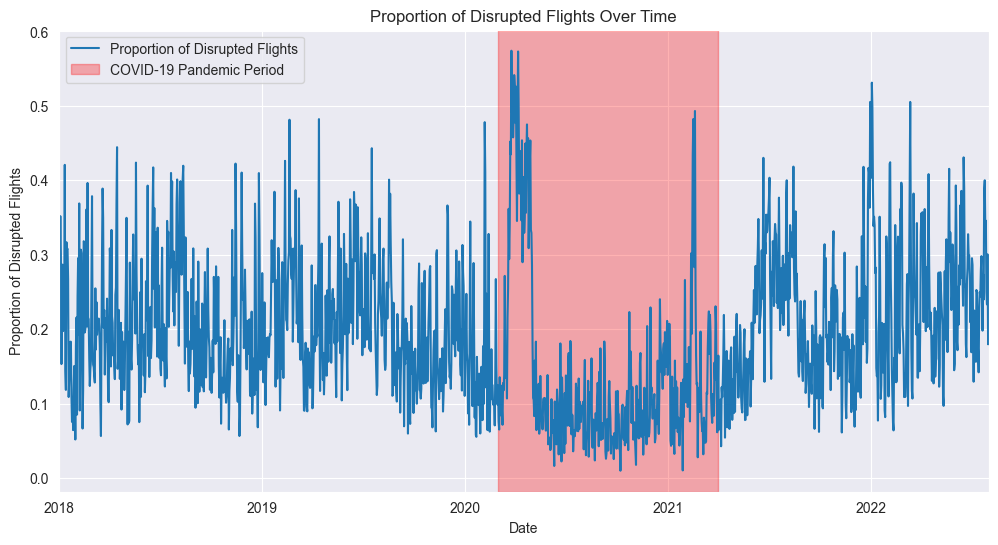

In [45]:
# Convert FlightDate to datetime
flights['FlightDate'] = pd.to_datetime(flights['FlightDate'])

# Calculate the total number of flights and the number of disrupted flights per day
total_flights_per_day = flights.groupby('FlightDate').size()
disrupted_flights_per_day = flights[flights['Disruption'] == 1].groupby('FlightDate').size()

# Calculate the proportion of disrupted flights per day
proportion_of_disrupted_flights = disrupted_flights_per_day / total_flights_per_day

# Set up the figure and axis
plt.figure(figsize=(12, 6))

# Plot the proportion of disrupted flights over time
proportion_of_disrupted_flights.plot(label='Proportion of Disrupted Flights')

# Highlight the COVID-19 pandemic period in 2020
plt.axvspan('2020-03-01', '2021-3-31', color='red', alpha=0.3, label='COVID-19 Pandemic Period')

plt.title('Proportion of Disrupted Flights Over Time')
plt.xlabel('Date')
plt.ylabel('Proportion of Disrupted Flights')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [46]:
flights['IsCovid'] = flights['FlightDate'].apply(lambda x: 1 if pd.Timestamp('2020-03-01') <= x <= pd.Timestamp('2021-3-31') else 0)

In [47]:
flights.head()

,FlightDate,Airline,Origin,Dest,Cancelled,Diverted,CRSDepTime,CRSElapsedTime,Distance,Year,...,DestStateFips,DestStateName,DestWac,DepTimeBlk,CRSArrTime,ArrDel15,ArrTimeBlk,DistanceGroup,Disruption,IsCovid
0,2018-07-13,United Air Lines Inc.,LAX,ORD,0,0,1845,231,1744,2018,...,17,Illinois,41,1800-1859,36,0.0,0001-0559,7,0.0,0
1,2018-06-26,Mesa Airlines Inc.,CRP,IAH,0,0,1757,60,201,2018,...,48,Texas,74,1700-1759,1857,0.0,1800-1859,1,0.0,0
2,2018-07-03,Southwest Airlines Co.,ECP,HOU,0,0,945,105,571,2018,...,48,Texas,74,0900-0959,1130,0.0,1100-1159,3,0.0,0
3,2018-10-28,United Air Lines Inc.,LAS,IAH,0,0,1015,171,1222,2018,...,48,Texas,74,1000-1059,1506,0.0,1500-1559,5,0.0,0
4,2018-11-01,ExpressJet Airlines Inc.,IAH,TUL,0,0,1856,90,429,2018,...,40,Oklahoma,73,1800-1859,2026,0.0,2000-2059,2,0.0,0


Training set: 23,352 samples
Test set: 5,839 samples

In [48]:
# Check for missing values in the dataset
missing_values = flights.isnull().sum()

# Display columns with missing values if any
missing_values[missing_values > 0]


Tail_Number    2696
ArrDel15       8483
Disruption       10
dtype: int64

In [49]:
null_disruptions = flights[flights['Disruption'].isnull()]
null_disruptions

,FlightDate,Airline,Origin,Dest,Cancelled,Diverted,CRSDepTime,CRSElapsedTime,Distance,Year,...,DestStateFips,DestStateName,DestWac,DepTimeBlk,CRSArrTime,ArrDel15,ArrTimeBlk,DistanceGroup,Disruption,IsCovid
2418,2018-04-08,Endeavor Air Inc.,JFK,ROC,0,0,1540,101,264,2018,...,36,New York,22,1500-1559,1721,NaN,1700-1759,2,NaN,0
6049,2018-04-09,Endeavor Air Inc.,LGA,GRR,0,0,2052,139,618,2018,...,26,Michigan,43,2000-2059,2311,NaN,2300-2359,3,NaN,0
17023,2018-04-03,Endeavor Air Inc.,IND,LGA,0,0,1857,123,660,2018,...,36,New York,22,1800-1859,2100,NaN,2100-2159,3,NaN,0
18576,2018-04-27,Endeavor Air Inc.,CVG,JFK,0,0,1435,125,589,2018,...,36,New York,22,1400-1459,1640,NaN,1600-1659,3,NaN,0
23849,2018-01-08,Endeavor Air Inc.,BGR,LGA,0,0,1225,114,378,2018,...,36,New York,22,1200-1259,1419,NaN,1400-1459,2,NaN,0
26619,2018-04-18,Endeavor Air Inc.,RDU,BWI,0,0,855,74,255,2018,...,24,Maryland,35,0800-0859,1009,NaN,1000-1059,2,NaN,0
27029,2018-04-07,Endeavor Air Inc.,BOS,RDU,0,0,1210,122,612,2018,...,37,North Carolina,36,1200-1259,1412,NaN,1400-1459,3,NaN,0
33794,2018-01-03,Endeavor Air Inc.,BUF,BOS,0,0,700,91,395,2018,...,25,Massachusetts,13,0700-0759,831,NaN,0800-0859,2,NaN,0
42460,2018-01-18,Endeavor Air Inc.,ATL,CSG,0,0,1954,51,83,2018,...,13,Georgia,34,1900-1959,2045,NaN,2000-2059,1,NaN,0
52458,2018-01-04,Endeavor Air Inc.,ATL,CSG,0,0,1954,51,83,2018,...,13,Georgia,34,1900-1959,2045,NaN,2000-2059,1,NaN,0


In [50]:
flights = flights.dropna(subset=['Disruption'])

In [51]:
# Summary of the dataset including data types, missing values, and unique counts for each attribute
summary = {
    'Attribute': flights.columns,
    'Data Type': flights.dtypes,
    'Missing Values': flights.isnull().sum(),
    'Unique Values': flights.nunique()
}

summary_df = pd.DataFrame(summary)
summary_df.reset_index(drop=True, inplace=True)
summary_df


,Attribute,Data Type,Missing Values,Unique Values
0,FlightDate,datetime64[ns],0,1673
1,Airline,object,0,28
2,Origin,object,0,387
3,Dest,object,0,386
4,Cancelled,int64,0,2
5,Diverted,int64,0,2
6,CRSDepTime,int64,0,1313
7,CRSElapsedTime,int64,0,564
8,Distance,int64,0,1668
9,Year,int64,0,5


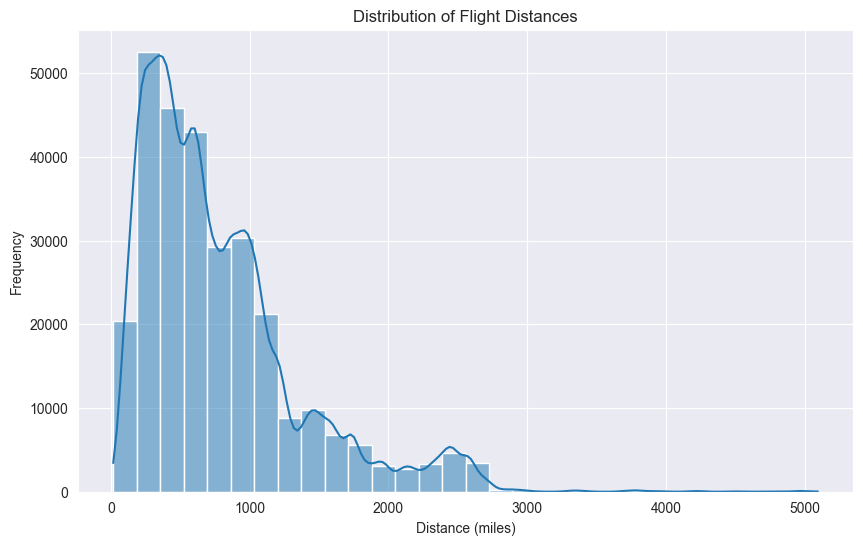

In [52]:
# Visualize the distribution of flight distances
plt.figure(figsize=(10, 6))
sns.histplot(flights['Distance'], bins=30, kde=True)
plt.title('Distribution of Flight Distances')
plt.xlabel('Distance (miles)')
plt.ylabel('Frequency')
plt.show()

- **New attributes (feature engineering)**
    - Part of Day (morning, afternoon, evening, night) from CRSDepTime.
    - Flight Type (short-haul, medium-haul, long-haul) based on Distance.


In [53]:
# Convert FlightDate to datetime to extract month and day of the week
flights['FlightDate'] = pd.to_datetime(flights['FlightDate'])
flights['Month'] = flights['FlightDate'].dt.month
flights['DayOfWeek'] = flights['FlightDate'].dt.dayofweek  # Monday=0, Sunday=6

# Feature Engineering
# Part of the Day
def part_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    else:
        return 'Night'

flights['PartOfDay'] = flights['CRSDepTime'].apply(lambda x: part_of_day(int(x/100)))

# Flight Type
flights['FlightType'] = pd.cut(flights['Distance'], bins=[0, 800, 2100, 10000], labels=['Short-Haul', 'Medium-Haul', 'Long-Haul'])

flights['Season'] = flights['FlightDate'].dt.month.apply(lambda x: 'Winter' if x in [12, 1, 2] else ('Spring' if x in [3, 4, 5] else ('Summer' if x in [6, 7, 8] else 'Autumn')))

Disruption % by Airline

In [54]:
# Group by 'Airline' and calculate the mean of 'Disruption' to get the disruption rate
disruption_rate = flights.groupby('Airline')['Disruption'].mean()

disruption_percentage = disruption_rate * 100

# Sort the airlines by disruption rate in descending order
disruption_percentage_sorted = disruption_percentage.sort_values(ascending=False)
disruption_percentage_sorted


Airline
Peninsula Airways Inc.                       48.000000
Allegiant Air                                29.683747
Trans States Airlines                        28.623188
Commutair Aka Champlain Enterprises, Inc.    28.441755
JetBlue Airways                              27.742274
Frontier Airlines Inc.                       26.420703
ExpressJet Airlines Inc.                     24.405575
GoJet Airlines, LLC d/b/a United Express     23.029422
Empire Airlines Inc.                         22.105263
Virgin America                               22.012579
Mesa Airlines Inc.                           21.870865
American Airlines Inc.                       21.643261
Spirit Air Lines                             21.409734
Air Wisconsin Airlines Corp                  21.126381
United Air Lines Inc.                        20.890613
Southwest Airlines Co.                       20.778598
Envoy Air                                    20.563459
Comair Inc.                                  20.473684
Ca

### Visualize proportion of disruption by each category

In [55]:
def plot_proportion_of_disruptions(flights_df, category):
    # Calculate the total number of flights for each category
    total_flights_by_cat = flights_df.groupby(category).size().reset_index(name='Total')

    # Calculate the number of disrupted and non-disrupted flights for each category
    disruption_by_cat = flights_df.groupby([category, 'Disruption']).size().reset_index(name='Count')

    # Merge the total flights with the count of disruptions
    proportion_by_cat = pd.merge(disruption_by_cat, total_flights_by_cat, on=category)

    # Calculate the proportion of disruptions
    proportion_by_cat['Proportion'] = proportion_by_cat['Count'] / proportion_by_cat['Total']

    # Pivot the data for plotting
    pivot_cat = proportion_by_cat.pivot(index=category, columns='Disruption', values='Proportion')

    # Plot the stacked bar chart
    pivot_cat.plot(kind='bar', stacked=True, figsize=(10, 7))

    plt.title(f'Proportion of Flight Disruptions by {category}')
    plt.xlabel(category)
    plt.ylabel('Proportion of Flights')
    plt.legend(title='Disruption', labels=['No Disruption', 'Disruption'])
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


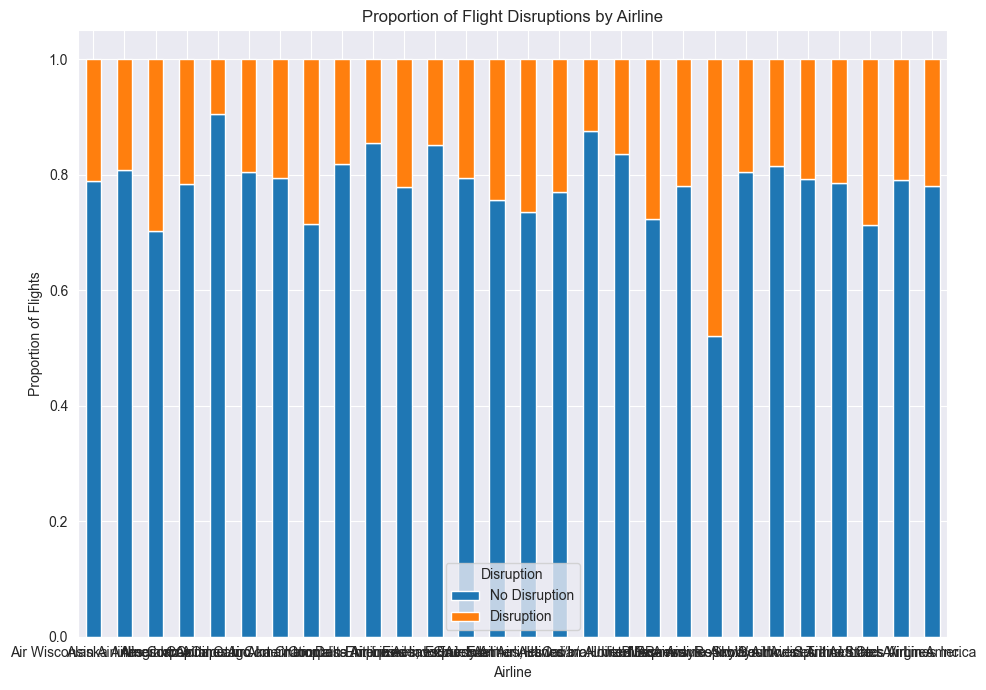

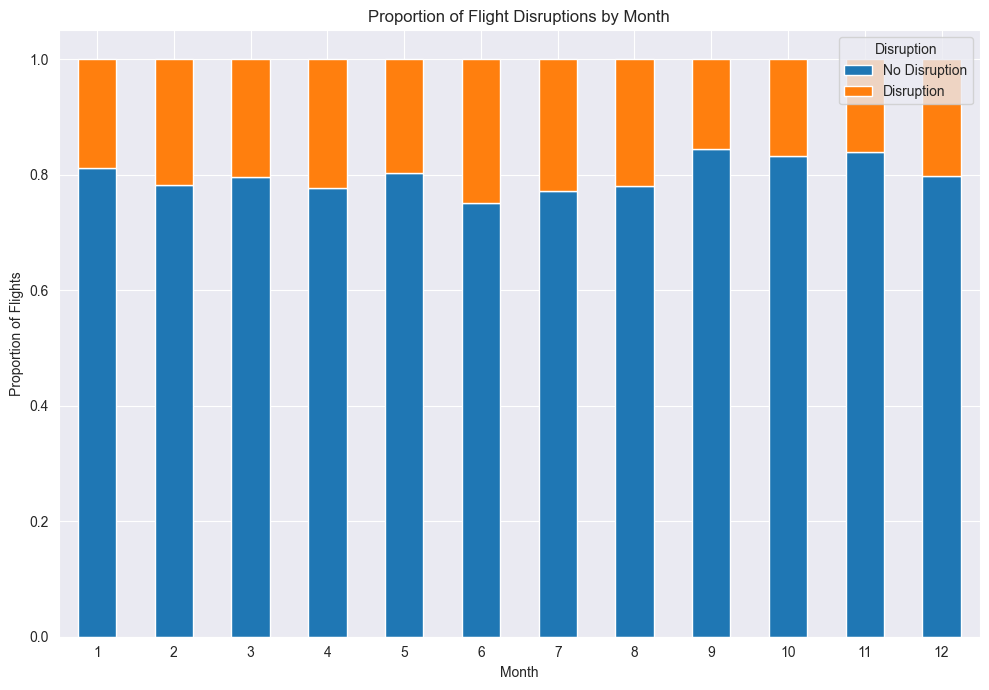

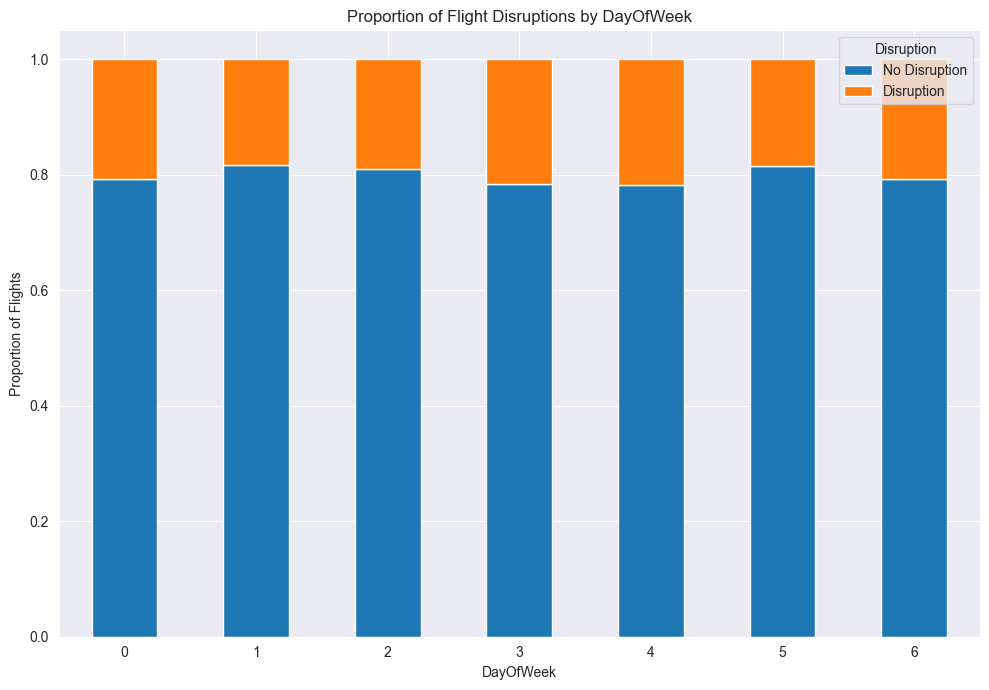

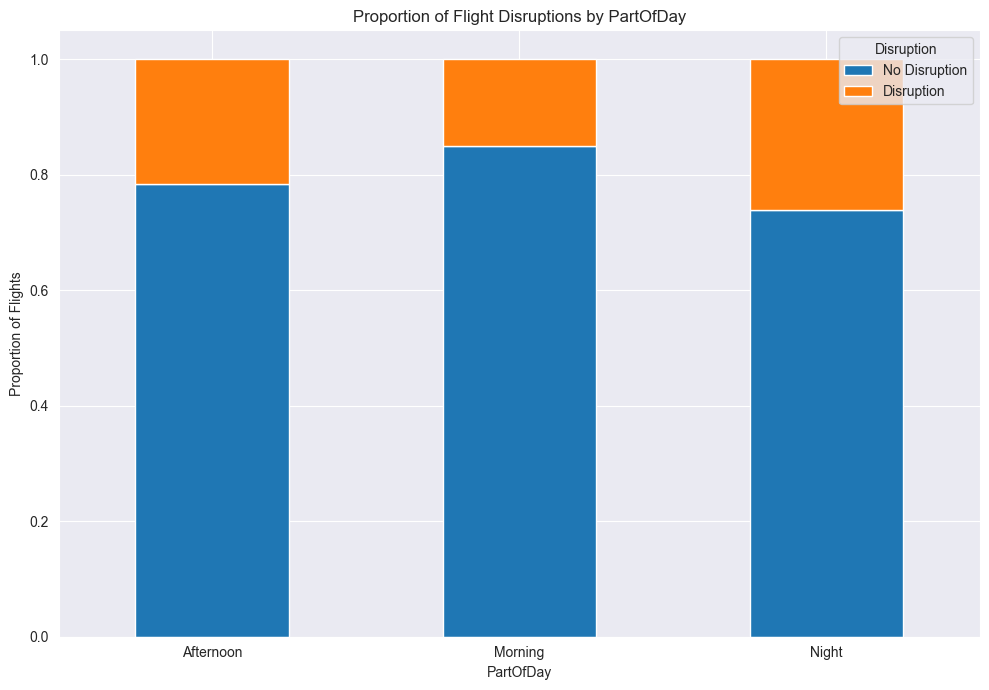

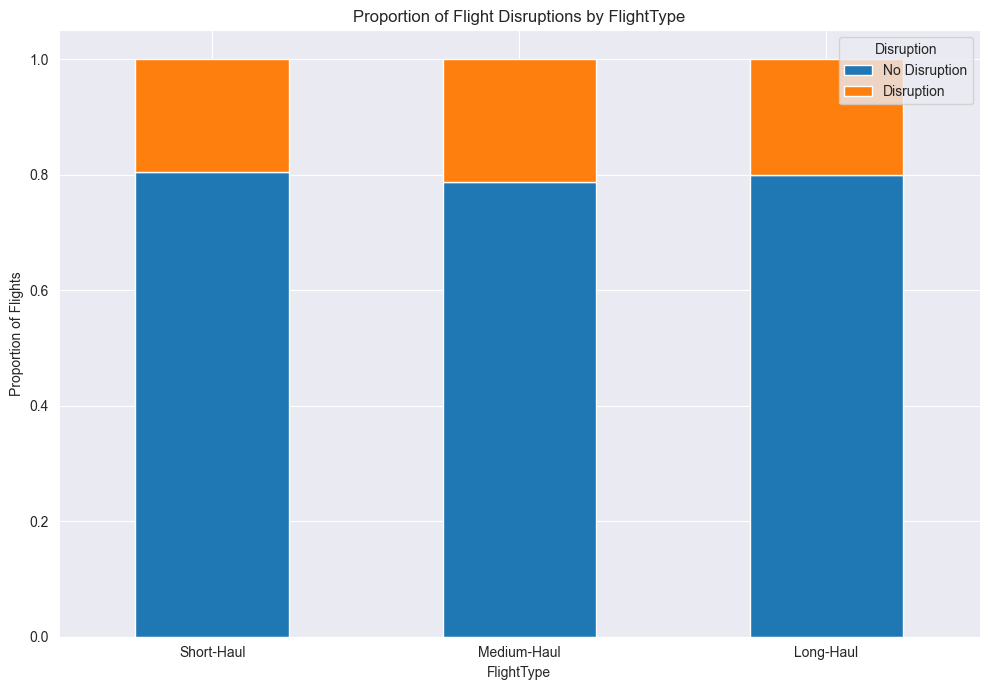

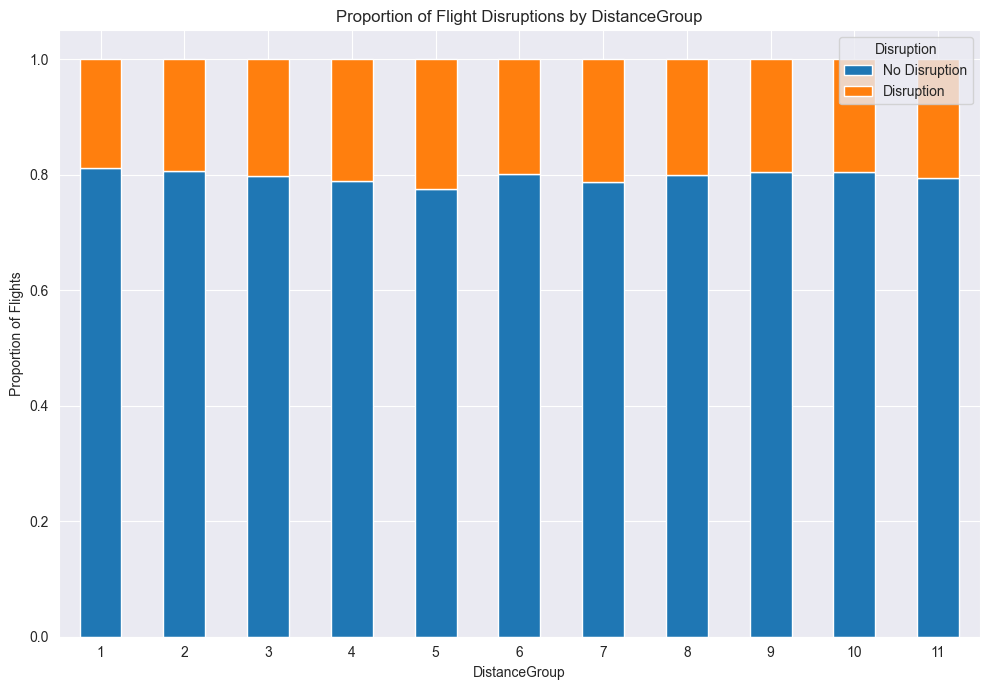

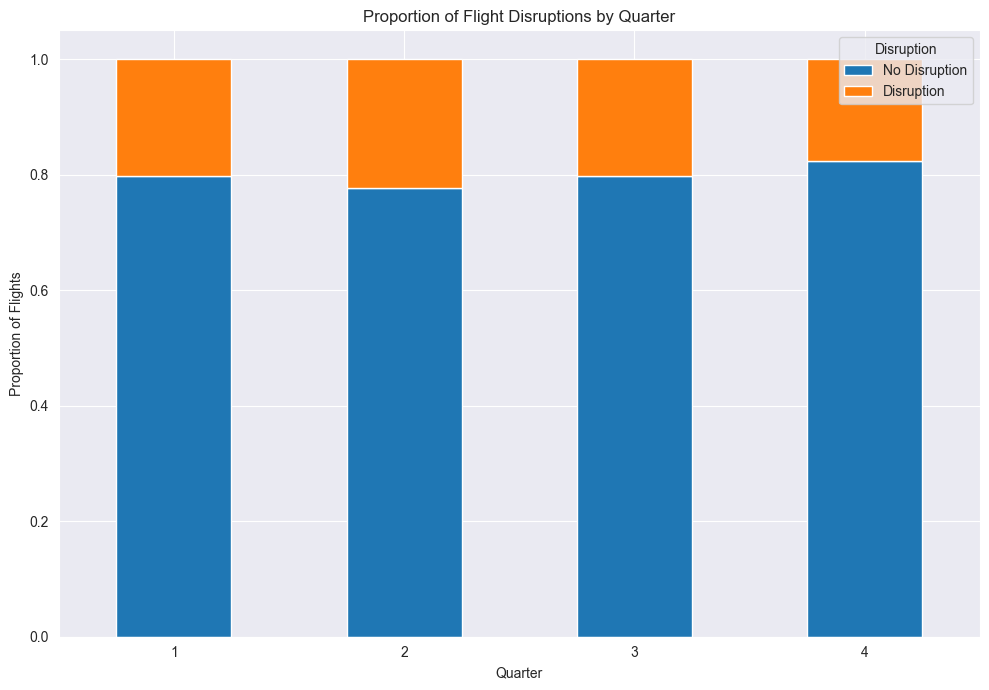

In [56]:
# List of categories to plot
categories = ['Airline', 'Month', 'DayOfWeek', 'PartOfDay', 'FlightType', 'DistanceGroup', 'Quarter']

# Plot proportion of disruptions for each category
for cat in categories:
    plot_proportion_of_disruptions(flights, cat)

- Disruption by Airline: Noticeable differences, indicating that the airline is a significant predictor of disruptions
- Disruption by Month: Seasonal trends are weak, with certain months showing slightly higher disruption rates
- Disruption by Day of Week: The disruption pattern varies slightly across different days
- Disruption by Part of Day: The time of day seems to affect disruption rates, with higher morning disruptions.
- Disruption by Flight Type: The flight type (short-haul, medium-haul, long-haul) shows varied disruption rates

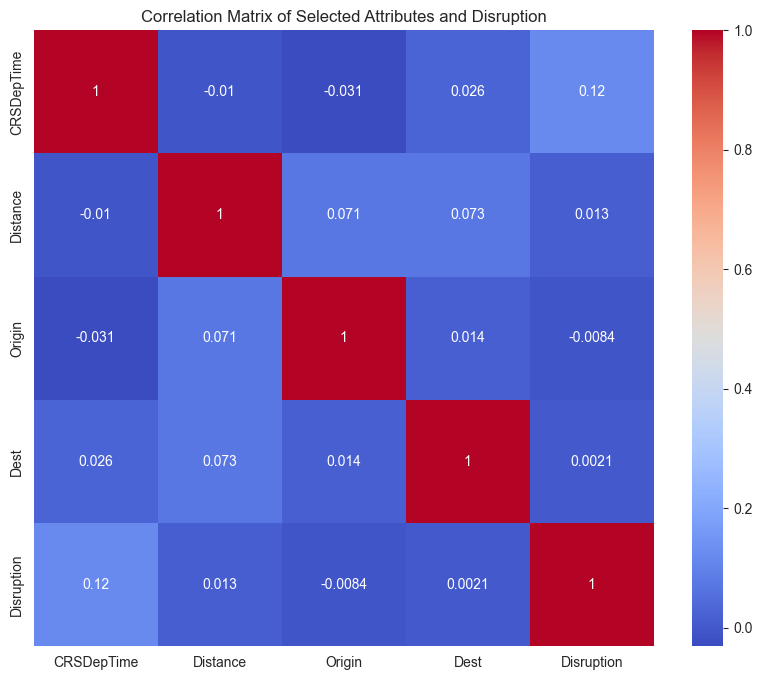

In [57]:
# Encode categorical variables
label_encoder = LabelEncoder()
categorical_columns = ['Month','DayOfWeek', 'Airline', 'Origin', 'Dest', 'OriginState', 'DestState', 'PartOfDay', 'Quarter','FlightType']
for col in categorical_columns:
    flights[col] = label_encoder.fit_transform(flights[col])

# Check the correlation between numerical attributes and disruptions
correlation_matrix = flights[['CRSDepTime', 'Distance', 'Origin', 'Dest', 'Disruption']].corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Selected Attributes and Disruption')
plt.show()


Porpotion of the dataset as Disruption

In [58]:
disruption_counts = flights['Disruption'].value_counts(normalize=True)
proportion_of_disruptions = disruption_counts.get(1, 0)
round(proportion_of_disruptions,4)

0.2017

In [59]:
features = ['Month','DayOfWeek','Airline', 'Origin', 'Dest', 'FlightType', 'OriginState', 'DestState', 'PartOfDay', 'Quarter']

X = flights[features]  # Features 
y = flights['Disruption'] # Target variable
class_weights = {0: 1, 1: 4} # Address the class imbalance
# Stratified train-test split with a test size of 20% - also speed up fitting process compare with cross-validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Model 1 - Ensemble Logistics Regression - Benchmark

In [60]:
# Initialize a default logistic regression model
base_model = LogisticRegression(random_state=42, class_weight=class_weights)
ensemble = BaggingClassifier(base_estimator=base_model, n_estimators=120, random_state=42)

# Train the model
ensemble.fit(X_train, y_train)

# Make predictions on the test set
y_pred = ensemble.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}\n")
print(f"Confusion Matrix:\n{conf_matrix}\n")
print(f"Classification Report:\n{class_report}")


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Accuracy: 0.5072878307784534

Confusion Matrix:
[[23106 23500]
 [ 5267  6512]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.50      0.62     46606
         1.0       0.22      0.55      0.31     11779

    accuracy                           0.51     58385
   macro avg       0.52      0.52      0.46     58385
weighted avg       0.69      0.51      0.55     58385



### Model 2 - Random Forest - Benchmark

In [61]:
rfc_benchmark = RandomForestClassifier(class_weight=class_weights, random_state=42)

# Train the classifier on the training set
rfc_benchmark.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rfc_benchmark.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Generate confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Display accuracy, confusion matrix, and classification report
print(f"Accuracy: {accuracy}\n")
print(f"Confusion Matrix:\n{conf_matrix}\n")
print(f"Classification Report:\n{class_report}")
print("Hyperparameters of the trained model:\n")
for attr, value in rfc_benchmark.get_params().items():
    print(f"{attr}: {value}")


Accuracy: 0.7649567525905626

Confusion Matrix:
[[43457  3149]
 [10574  1205]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.93      0.86     46606
         1.0       0.28      0.10      0.15     11779

    accuracy                           0.76     58385
   macro avg       0.54      0.52      0.51     58385
weighted avg       0.70      0.76      0.72     58385

Hyperparameters of the trained model:

bootstrap: True
ccp_alpha: 0.0
class_weight: {0: 1, 1: 4}
criterion: gini
max_depth: None
max_features: sqrt
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 100
n_jobs: None
oob_score: False
random_state: 42
verbose: 0
warm_start: False


The RandomForestClassifier exhibits an accuracy of 76%, effectively identifying the non-disruptive instances (label 0). However, it faces challenges in accurately classifying the disruptive instances (label 1), which is critical for our analysis. This discrepancy underscores the need for model refinement to better capture disruptions, aligning with our primary objective.

To address this, the focus will shift to tree pruning and parameter fine-tuning, specifically:
- `max_depth` to control the depth of the trees,
- `min_samples_split` to determine the minimum number of samples required to split an internal node, and
- `min_samples_leaf` to set the minimum number of samples required to be at a leaf node.

These adjustments are intended to counteract overfitting by limiting decision tree complexity, thereby improving the model's generalization ability across both classes while maintaining satisfactory accuracy levels.


In [62]:
# Define the parameter distributions with three choices each
param_distributions = {
    'max_depth': [5, 10, 15],  # Default is None, , lower values prevent overfitting
    'min_samples_split': [3, 6, 9],  # Default is 2, higher values prevent overfitting
    'min_samples_leaf': [2, 4, 6],  # Default is 1, higher values prevent overfitting
}

# Initialize RandomForestClassifier with class weights to handle class imbalance
rfc = RandomForestClassifier(class_weight=class_weights, random_state=42)

# Initialize RandomizedSearchCV with 5-fold cross-validation to increase robustness
random_search_rfc = RandomizedSearchCV(
    estimator=rfc,
    param_distributions=param_distributions,
    n_iter=10,
    scoring='accuracy',  # Using accuracy as the scorer
    cv=5,  # 5-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit RandomizedSearchCV to the training data
random_search_rfc.fit(X_train, y_train)

# Print the best parameters and the best accuracy score
print("Best parameters found: ", random_search_rfc.best_params_)
print("Best accuracy score found: ", random_search_rfc.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters found:  {'min_samples_split': 3, 'min_samples_leaf': 4, 'max_depth': 15}
Best accuracy score found:  0.6767491650252635


### Model 3 - Random Forest - Fine-tuned

In [63]:
# Initialize the classifier with the given class weights
rfc = RandomForestClassifier(n_estimators=120, min_samples_split=3, min_samples_leaf=4,
                             class_weight=class_weights, max_depth=15, random_state=42)


# Train the classifier on the training set
rfc.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rfc.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Generate confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Display accuracy, confusion matrix, and classification report
print(f"Accuracy: {accuracy}\n")
print(f"Confusion Matrix:\n{conf_matrix}\n")
print(f"Classification Report:\n{class_report}")


Accuracy: 0.6725871371071337

Confusion Matrix:
[[34108 12498]
 [ 6618  5161]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.73      0.78     46606
         1.0       0.29      0.44      0.35     11779

    accuracy                           0.67     58385
   macro avg       0.56      0.58      0.57     58385
weighted avg       0.73      0.67      0.69     58385



### Summary Measures

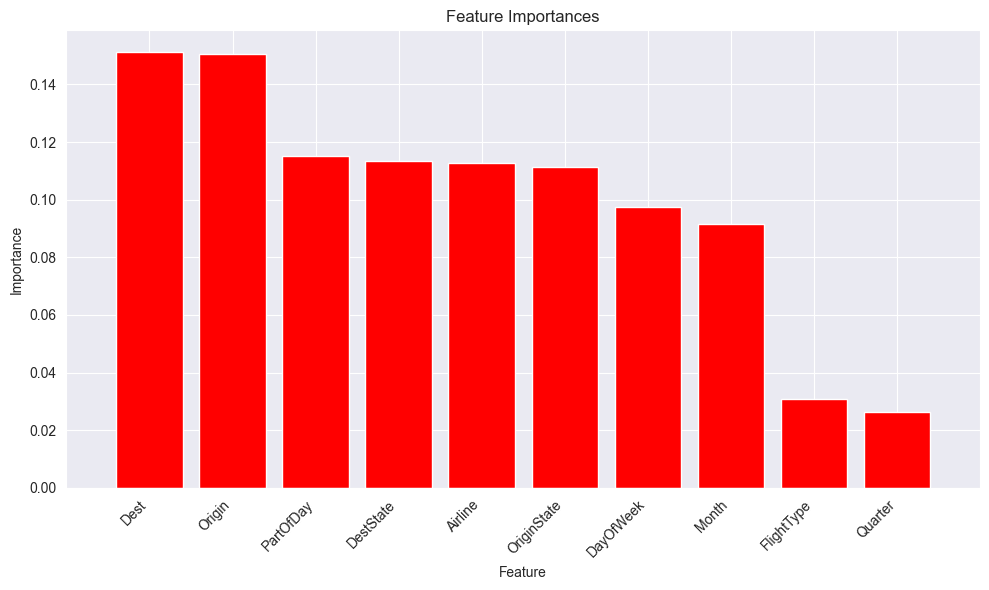

In [64]:
# Examine variable importance from the fitted model on the training set
feature_importances = rfc.feature_importances_
indices = np.argsort(feature_importances)[::-1]
feature_names_sorted = [features[i] for i in indices]

# Plotting the feature importances
plt.figure(figsize=(10, 6))  # Optional: Adjust the figure size as needed
plt.title("Feature Importances")
plt.bar(range(len(feature_importances)), feature_importances[indices],
        color="r", align="center")
plt.xticks(range(len(feature_importances)), feature_names_sorted, rotation=45, ha="right")
plt.xlim([-1, len(feature_importances)])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.tight_layout()  # Optional: Improves the spacing between the plot elements
plt.show()

The chart shows that the features 'Dest' and 'Origin' are the most influential in the model's predictions, with other variables contributing more evenly

Sample Decision Tree

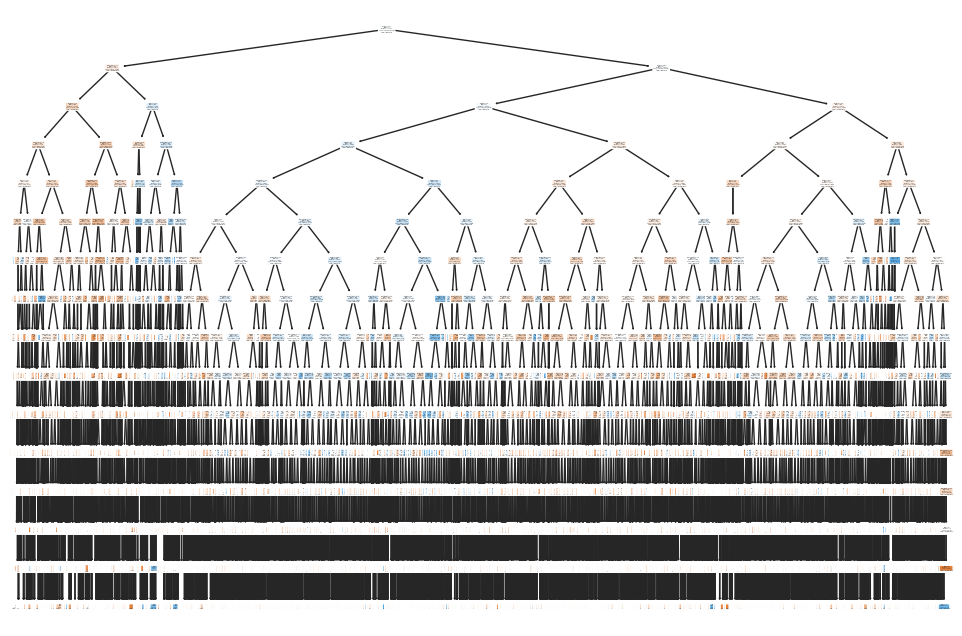

In [65]:
tree = rfc.estimators_[1]
plt.figure(figsize=(12, 8))
plot_tree(tree,
          feature_names=features,
          class_names=['No Disruption', 'Disruption'],
          filled=True,
          rounded=True)
plt.show()

The complexity of the decision tree, as seen in the visualization, points to potential overfitting. This complexity can be traced back to the findings in the correlation matrix, where it was observed that the available variables have a weak correlation with the occurrence of disruption, suggesting the presence of noisy and unbalanced data.

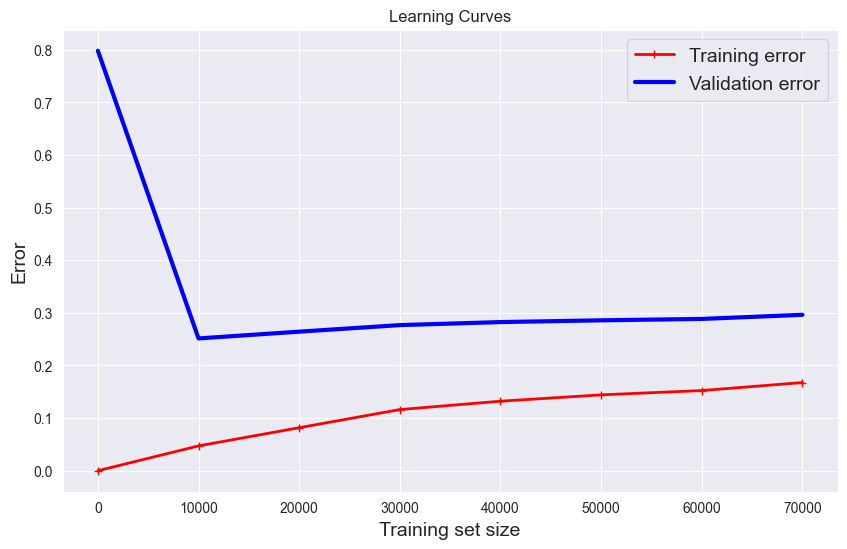

In [66]:
def plot_learning_curves(model, X, y, steps=10000, max_data_points=100000):
    # Subsample the dataset to make the process faster and more manageable
    X_sub, _, y_sub, _ = train_test_split(X, y, train_size=max_data_points, random_state=42, stratify=y)
    
    X_train, X_val, y_train, y_val = train_test_split(X_sub, y_sub, test_size=0.2, random_state=42, stratify=y_sub)
    train_errors, val_errors = [], []
    m_values = range(1, len(X_train), steps)

    for m in m_values:
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)

        train_accuracy = accuracy_score(y_train[:m], y_train_predict)
        val_accuracy = accuracy_score(y_val, y_val_predict)

        train_errors.append(1 - train_accuracy)
        val_errors.append(1 - val_accuracy)

    plt.figure(figsize=(10, 6))
    plt.plot(m_values, train_errors, "r-+", linewidth=2, label="Training error")
    plt.plot(m_values, val_errors, "b-", linewidth=3, label="Validation error")
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("Error", fontsize=14)
    plt.title("Learning Curves")
    plt.show()

plot_learning_curves(rfc, X, y)

The learning curve shows converging training and validation errors as the training set size increases, indicating fair generalization.

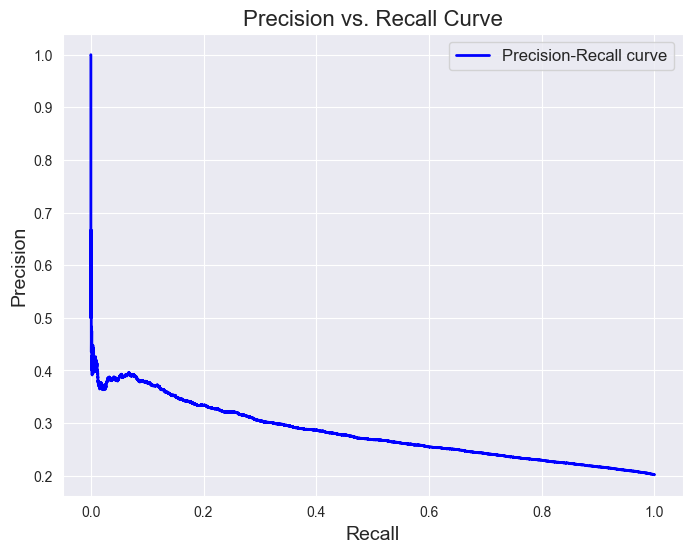

In [67]:
y_scores = rfc.predict_proba(X_test)[:, 1]  # get the scores for the positive class

# Compute precision-recall pairs
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

# Plotting the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, "b-", linewidth=2, label='Precision-Recall curve')
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision vs. Recall Curve', fontsize=16)


plt.legend(loc="best", fontsize=12)
plt.grid(True)
plt.show()



The precision-recall curve suggests that it's difficult to balance recall and precision for class 1. It's easier to achieve high precision in this extremely imbalanced datasets, as predicting everything as non-disruption will get a perfect precision.

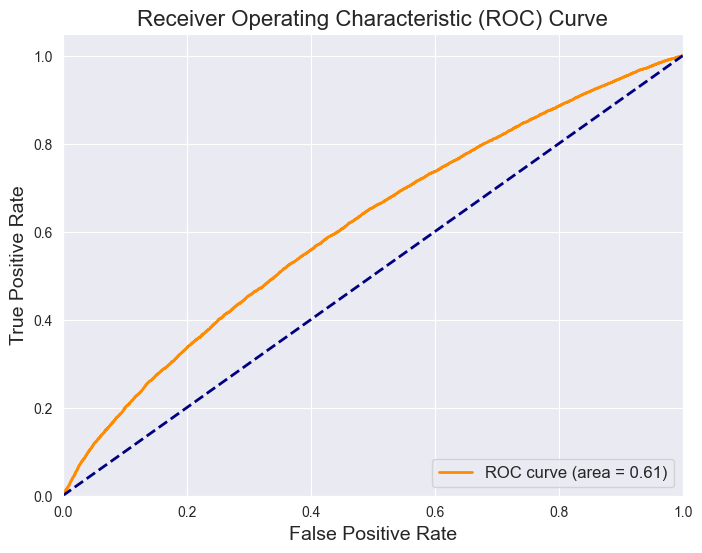

In [68]:
# Get the probability scores of the positive class
y_scores = rfc.predict_proba(X_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()


The ROC curve shows a trade-off between the true positive rate (TPR) and the false positive rate (FPR), with an AUC score of 0.61 indicating the beyond random guessing classification performance